<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NEURO-421)</h2>
<hr style="clear:both"></hr>
<h1><font color='black'>Multivariate approaches: PCA, ICA, PLS</font></h1>



<div class = 'alert alert-info'>
In this lab, we are going to apply different multivariate techniques to fMRI data: PCA, Group ICA, Tensor ICA and PLS.
    
</div>

In [2]:
!pip install tqdm
!pip install fury
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install tensorly

  Using cached fury-0.8.0-py3-none-any.whl (349 kB)
     |████████████████████████████████| 64.0 MB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 360 kB 19.4 MB/s eta 0:00:01
  Using cached multidict-6.0.2-cp39-cp39-macosx_10_9_x86_64.whl (28 kB)
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
     |████████████████████████████████| 61 kB 14.2 MB/s eta 0:00:01
  Using cached nistats-0.0.1rc0-py2.py3-none-any.whl (121 kB)


In [3]:
import os
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.viz import regtools
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

/opt/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# PCA 

fMRI analysis often has a dimensionality problem: we get approximately 100,000 voxels (features) per volume, but only 100s of time points or trials (examples). This makes it very hard for machine learning algorithms to model how each voxel contributes. 

In this part we will use principal component analysis (PCA) to reduce the dimensionality of the fMRI data. Some voxels may contain correlated information or no information, thus the original voxel-dimensional data matrix (time-by-voxels) can be projected into a lower-dimensional "component" matrix space (time-by-component) without losing significant information.

### Load the data

In [4]:
img = nib.load('PCA_data/ds114_sub009_t2r1.nii')
data = img.get_data()
data.shape

/var/folders/73/1hgyl4fx3jn3hxv46_v_x1xm0000gn/T/ipykernel_11300/538643163.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = img.get_data()


(64, 64, 30, 173)

### Preprocessing 

We can think of the shape of the data as two parts - the first 3 values are the 3D shape of the individual volumes, and the last value is the number of volumes. Put the 3D shape into a variable vol_shape and the number of volumes into a variable n_vols:

In [5]:
# Make variables:
# 'vol_shape' for shape of volumes
# 'n_vols' for number of volumes
# YOUR CODE HERE
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]

We are going to take the time axis as containing the “features”. We will take the voxels as being the “samples”. We start by taking the first two features (time points). Slice the data array to make a new array that contains only the first two volumes. 

In [6]:
# YOUR CODE HERE
# Slice the image data array to give array with only first two volumes
first_two = data[..., :2]
first_two.shape

(64, 64, 30, 2)

How many voxels are there in one volume? Put this number in a variable N. After that reshape the new two-volume data array to have a first dimension length N and second dimension length 2. Each of the two columns corresponds to the voxels for a whole volume. Take the transpose of this array to get a 2 by N array, ready for the PCA. 

In [7]:
# YOUR CODE HERE
# Set N to be the number of voxels in a volume
N = np.prod(vol_shape)
# Reshape to 2D array with first dimension length N
first_two = first_two.reshape((N, 2))
first_two.shape
# Transpose to 2 by N array
first_two = first_two.T
first_two.shape

(2, 122880)

Calculate the mean across columns (row means). Put these means into a variable row_means. Expand the row_means vector out to a 2 by N array by using np.outer and a vector of ones. Subtract this expanded 2 by N means array from the 2 by N data matrix and put the result into a variable X. Print the means across columns (row means) to check they are now very close to 0. 

In [8]:
# YOUR CODE HERE
# Calculate the mean across columns
row_means = np.mean(first_two, axis=1)
# Row means copied N times to become a 2 by N array
row_means = np.outer(row_means, np.ones(N))
# Subtract the means for each row, put the result into X
X = first_two - row_means
# Show the means over the columns, after the subtraction
np.mean(X, axis=1)

array([-1.51582450e-14,  1.36424205e-13])

Now we will plot the two rows against each other to get a feel for the variation. Remember that each row in X is a volume, so you are plotting the signal from the first volume against the corresponding signal for the second volume.

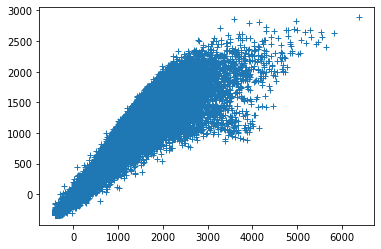

In [9]:
# Plot the signal in the first row against the signal in the second
plt.plot(X[0], X[1], '+')

### Apply PCA

Compute the covariance matrix of X. Apply SVD to get the U, S and VT matrices. Plot the first row in X against the second row in X again. This time add a line to the plot that corresponds to the first principal component. You’ll have to scale this line (a unit vector) to make it long enough to see on the axes of the plot. 

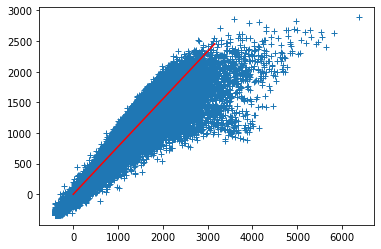

In [12]:
# YOUR CODE HERE 

# Compute the covariance matrix 
covariance_matrix = X.dot(X.T)

# Apply SVD to get U, S, VT matrices from covariance matrix
U, S, VT = np.linalg.svd(covariance_matrix)

# Plot the signal in the first row against the signal in the second
# Plot line corresponding to a scaled version of the first principal component
plt.plot(X[0], X[1], '+')
scaled_u = U[0, :] * -4000
plt.plot([0, scaled_u[0]], [0, scaled_u[1]], 'r')

Remember the projection formula $c = \hat{u}\cdot \vec{v}$. We now need to calculate the scalar projections $c$
for each component $\hat{u}$ and each voxel (each $\vec{v}$). 

This will give us a new output matrix of scalar projections C of shape (2, N), where the rows give the scalar projections for one component, and the columns give the coefficients for one voxel.

For example, C[0, 0] will be the result of U[0, :].dot(X[:, 0]), C[0, 1] will be the result of U[0, :].dot(X[:, 1]), and C[1, 0] will be the result of U[:, 1].dot(X[:, 0]).

In [13]:
# YOUR CODE HERE
# Calculate the scalar projections for projecting X onto the vectors in U.
# Put the result into a new array C.
C = U.T.dot(first_two)
C.shape

(2, 122880)

Remember that C - the matrix of scalar projections – has one column per voxel. We can think of each row as corresponding to a volume where the volumes are contained in: C[0] (first row of C) – scalar projections for first principal component; C[1] (second row of C) – scalar projections for second principal component.

We will take the transpose of C and reshape the resulting first dimension (length N) back to vol_shape - the original shape of the 3D volumes in the data. Finally, we will break this 4D array up into two volumes (volume for first component, volume for second component) using slicing:

In [14]:
# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols = C.T.reshape(vol_shape + (2,))
C_vols.shape

#- Break 4D array into two 3D volumes
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

Show the middle plane (slice over the third dimension) from the volume of scalar projections for the first component. 

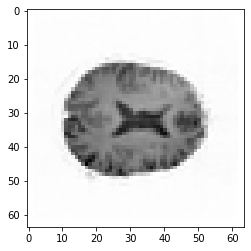

In [15]:
# YOUR CODE HERE
plt.imshow(vol0[:, :, 14], cmap='gray')

Show the middle plane (slice over the third dimension) from the volume of scalar projections for the second component.  

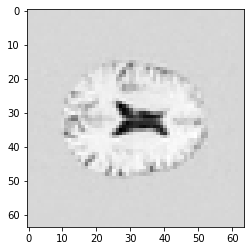

In [16]:
# YOUR CODE HERE
plt.imshow(vol1[:, :, 14], cmap='gray')

Run the same pipeline for all the time points, instead of just the first two.

# PLS

For the PLS analysis, we are going to use $n=20$ subjects with one contrast map (image, dim: [91, 109, 91] ) per subject. So in total, the number of input imaging data ($\textbf{X}$) is 20 flattened contrast maps ($X_{im} \in {\rm I\!R^{d_{im} \times n}}, d_{im}= 902629, n = 20$) ). 
    
For the behavioural input data ($\textbf{Y}$), two behavioural scores per subjects are used ($Y_{beh} \in {\rm I\!R^{d_{beh} \times n}}, d_{beh}= 2, n = 20$) ).

### Read contrast maps of all subjects

In [17]:
#* Read  contrast maps of all subjects and build the X matrix
data_dir_template = 'PLS_data/sub_{}/contrastMap.nii'

N_subj = 20                      # Number of subjects
tmp    = nib.load(data_dir_template.format(1))
x1, y1, z1 = tmp.shape              # voxel size of the contrast maps

tmp    = tmp.get_fdata().flatten()
N_vox  = tmp.shape[0]    # Number of voxels
del tmp

#* initialize X
X      = np.zeros((N_vox, N_subj)) # voxel_num X subj_num

for i in range(N_subj):
    voxel_array = nib.load(data_dir_template.format(i+1)).get_fdata().flatten()
    X[:,i]      = voxel_array.copy()
    
X      = zscore(X, axis = 0) # z-scoring voxel activity across subjects
X      = np.nan_to_num(X,0) # replace nan with 0s

print("X matrix size: ", X.shape)

X matrix size:  (902629, 20)


### Read behavioral data 

In [19]:
#* Read behavioral data and build the Y matrix
behVar = loadmat('PLS_Data/behavior.mat')['behVar']

Y = np.zeros(behVar.shape) # size: N_beh x N_subj
Y[0,:] = zscore(behVar[0,:])    # z-scoring of the first measure
Y[1,:] = zscore(behVar[1,:])    # z-scoring of the second measure

print("Y matrix size: ", Y.shape)

Y matrix size:  (2, 20)


### Build the cross-correlation matrix R and apply SVD

In [20]:
#* Build the cross-correlation matrix (R)
R     = np.dot(Y,X.T); # size: N_beh x N_vox
print("R matrix size: ", R.shape)

#* Do Singular Value Decomposition (SVD) of R
# U: N_beh x N_beh, D: N_beh x 1, V: N_beh x N_vox
# YOUR CODE HERE
U,D,V = np.linalg.svd(R, full_matrices = False)

print("U matrix size :", U.shape, "D matrix size :", D.shape, "V matrix size :", V.shape)

#* Get the Latent Variables LVs
# Lx (size: N_beh x N_subj)
# Ly= (size: N_beh x N_subj)
# YOUR CODE HERE
Lx = np.matmul(V, X)
Ly = np.matmul(U, Y)

print("Latent var x :", Lx.shape, "Latent var y :", Ly.shape)
print('Number of singular values is equal to the number of behavioral measures: ', D.shape[0])

R matrix size:  (2, 902629)
U matrix size : (2, 2) D matrix size : (2,) V matrix size : (2, 902629)
Latent var x : (2, 20) Latent var y : (2, 20)
Number of singular values is equal to the number of behavioral measures:  2


### Plot singular values, behavioral components and spatial components


 The Singular values:  [2552.18920751   12.92148597]


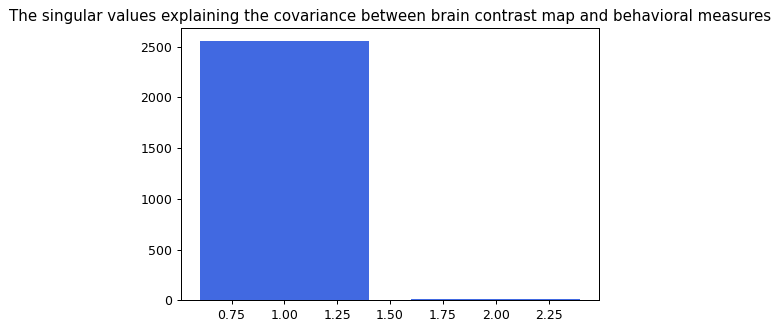

In [21]:
#* Plot singular values explaining the covariance between brain contrast maps and behavioral measures

plt.figure(dpi=90)
plt.bar([1,2], D,color='royalblue')
plt.title("The singular values explaining the covariance between brain contrast map and behavioral measures")

# YOUR CODE HERE
#raise NotImplementedError()

# Print the Sigular values
print("\n The Singular values: ", D)

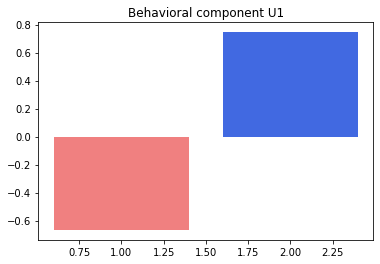

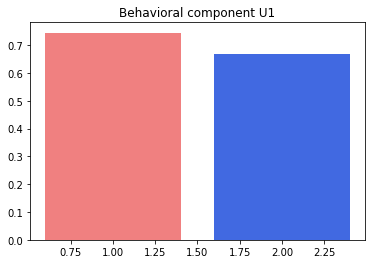

In [22]:
#* Plot the behavioral components (matrix U)

# Plot Behavioral Component U1
plt.bar([1,2], U[0,:], color=['lightcoral','royalblue'])
plt.title("Behavioral component U1")
plt.show()

# Plot Behavioral Component U2
# YOUR CODE HERE
plt.bar([1,2], U[1,:], color=['lightcoral','royalblue'])
plt.title("Behavioral component U1")
plt.show()

In [23]:
#* Information needed for plotting
#* Read T1-weighted template
T1w_img = nib.load('PLS_data/T1w_restore_brain.nii')

# Get affine transform
affine = nib.load(data_dir_template.format(1)).affine

Spatial Component V1
Spatial Component V2


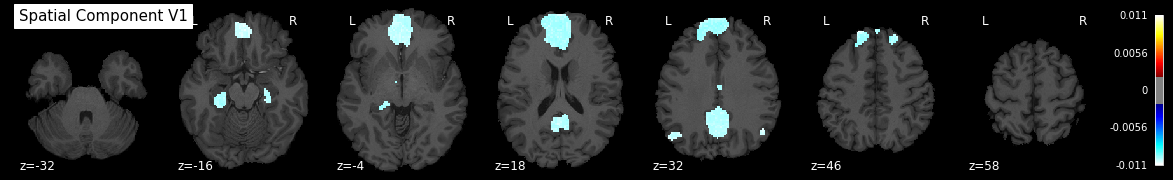

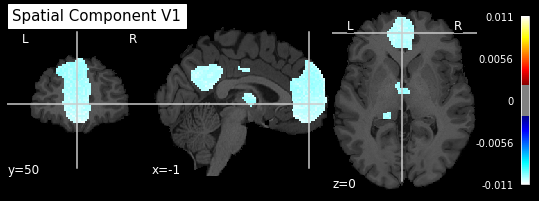

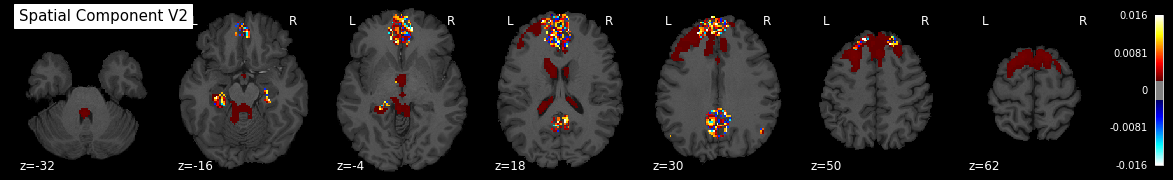

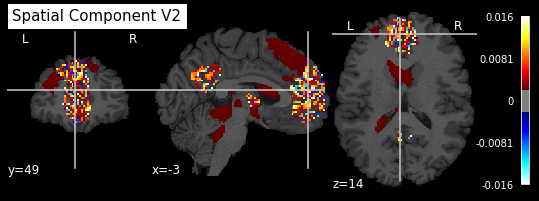

In [25]:
#* Plot the spatial components (matrix V)
print('Spatial Component V1')
V1_img = nib.Nifti1Image(np.reshape(V[0,:],(x1, y1, z1)), affine)

#* Plot different views
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plot_stat_map(V1_img, display_mode=view_, title='Spatial Component V1',
                    colorbar=True, black_bg=True, bg_img=T1w_img, threshold=2*np.std(V[0,:]),)
                    #output_file=save_results + "pls_spatial_V1_{}.png".format(view_)) # uncomment to save plot
        
print('Spatial Component V2')  
# YOUR CODE HERE
V2_img = nib.Nifti1Image(np.reshape(V[1,:],(x1, y1, z1)), affine)

#* Plot different views
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plot_stat_map(V2_img, display_mode=view_, title='Spatial Component V2',
                colorbar=True, black_bg=True, bg_img=T1w_img, threshold=2*np.std(V[1,:]),)
                #output_file=save_results + "pls_spatial_V2_{}.png".format(view_)) # uncomment to save plot


Note that the area highlighted correspond to Posterior Cingulate Cortex (PCC) and the Medial Prefrontal Cortex (mPFC) - belonging to the so called DMN - and that those regions contribute significantly to the brain-behavior covariance matrix R.

# Spatial & Temporal ICA 

In order to understand the main process, let's start with a toy-example: a 2D image (x-y) whose pixels are associated to a time-series. To simplify and simulate that this 2D image might change in time, we will consider 3 channels (3 different states that correspond to the ground truth 3 components that we want to emulate). 

In this way we are trying to simplify what we have in real data fMRI: a volume (3D) that represents the brain with its time-varying activity (4th dimension).

Let's start with generating a simulated image that is characterized by 3 clear groups that we want to distinguish and identify with ICA.


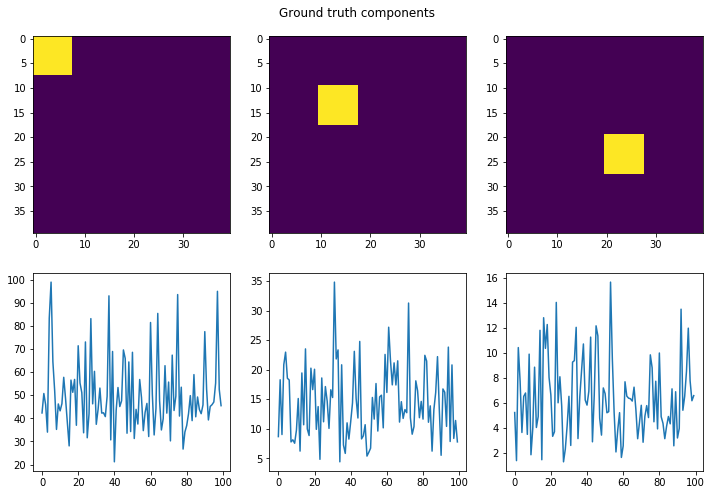

In [4]:
nTRs=100 # number of timepoints in the fMRI timecourse
nComps=3 # number of ground-truth components

# put together synthetic data (2D x time)
t=range(0,nTRs) 
pS=8 # patch size (size of each small square/ground truth group)
iS=40 # image size

I = np.zeros([3,iS,iS])
T = np.empty([3,1,1,nTRs])

# channel 0
I[0,:,:]=np.zeros([iS,iS])
I[0,:,:][0:0+pS,0:0+pS]=1
T[0]=np.random.gamma(10,5,[1,1,nTRs])
# channel 1
I[1,:,:]=np.zeros([iS,iS])
I[1,:,:][10:10+pS,10:10+pS]=1
T[1]=np.random.gamma(5,3,[1,1,nTRs])
# channel 2
I[2,:,:]=np.zeros([iS,iS])
I[2,:,:][20:20+pS,20:20+pS]=1
T[2]=np.random.gamma(3,2,[1,1,nTRs])

# plot ground truth images and time courses of the 3 channels, with the corresponding timeseries
# Hint: use imshow for the matrix

### YOUR CODE HERE
### BEGIN SOLUTION
fig = plt.figure(figsize=[12,8])
plt.subplot(2,3,1) 
plt.imshow(I[0])

plt.subplot(2,3,2) 
plt.imshow(I[1])
plt.subplot(2,3,3) 
plt.imshow(I[2]) 
plt.subplot(2,3,4)
plt.plot(np.squeeze(T[0]))
plt.subplot(2,3,5); 
plt.plot(np.squeeze(T[1]))
plt.subplot(2,3,6); 
plt.plot(np.squeeze(T[2]))
fig.suptitle('Ground truth components',y=0.93)
plt.show()
### END SOLUTION

In [5]:
# Generate fake fMRI data (in 3D instead of 4D)
# shaping the data into 3D data object

data=np.zeros([iS,iS,nTRs])
for i in range(nComps):
    # repeat the 3 states that we want to identify with the spatial ICA
    repeatedI = np.array([I[i] for x in range(nTRs)]).T
    data=data+repeatedI*np.tile(T[i],[iS,iS,1])

# RUN Spatial ICA

## FastICA (reorient data in 2D matrix)
## Lecture slides show convention: 1 observation in 1 row
## FastICA Python toolbox assumes 1 observation in 1 column

x = np.reshape(data,[iS*iS, nTRs])
print("The X matrix has dimensions {} and it's going to be used as input to spatial or temporal ICA. \n\
Be careful for the distinction of the 2!\n".format(x.shape))

# perform ICA using the algorithm FastICA imported from sklearn.decomposition 
# (CHECK THE DOCUMENTATION TO SEE HOW TO USE IT)

### YOUR CODE HERE

## First: use ICA on the SPATIAL axis
# icasig_space = ...
icas = FastICA(n_components=nComps)#, random_state=9
icasig_space = icas.fit_transform(x)  # Spatial source signals

## Then apply again ICA but on the temporal axis 
# icasig_time = ...
icat = FastICA(n_components=nComps) #, random_state=9
icasig_time = icat.fit_transform(x.T)  # Temporal source signals


## Then reshape spatial sources into 2D images
C = np.empty([nComps, iS, iS])
for i in range(nComps):
    C[i]=np.reshape(icasig_space[:,i],[iS,iS])

    
print("The shape of C is :", C.shape)


The X matrix has dimensions (1600, 100) and it's going to be used as input to spatial or temporal ICA. 
Be careful for the distinction of the 2!

The shape of C is : (3, 40, 40)


Now, try to re-run the same code doing 2 changes at the time:

1) Increasing the value of the variable of the patch size `pS` to 12, meaning that we will create a small overlap between the blocks;

2) Changing the number of components of only the ICA (keeping the ground truth to 3).

Run the ICA again a few times and observe the results. What can you say with respect to the sorting and sign of the components? What about increasing the patch size?

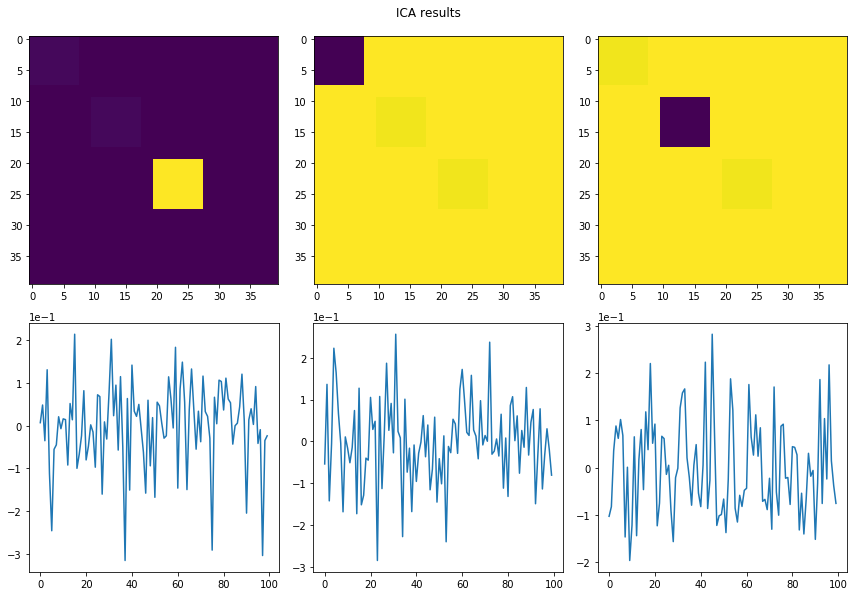

In [8]:
# Now plot spatial and temporal ICA sources similarly as before:
# the 3 NxN matrices (in space) with the respective time components stored in the variable icasig_t

### BEGIN SOLUTION
fig = plt.figure(figsize=[12,8])
plt.suptitle('ICA results',y=1.03)

plt.subplot(2,3,1)
plt.imshow(C[0])

plt.subplot(2,3,2)
plt.imshow(C[1])

plt.subplot(2,3,3)
plt.imshow(C[2])

plt.subplot(2,3,4)
plt.plot(np.squeeze(icasig_time[:,0]))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(2,3,5)
plt.plot(np.squeeze(icasig_time[:,1]))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(2,3,6)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(np.squeeze(icasig_time[:,2]))

plt.tight_layout()
plt.show()
### END SOLUTION

## Group ICA 

For the Group ICA analysis, we are going to use data from studyforest. Subjects are watching the movie "forest gump" during fMRI acquisition. Here we take $n=15$ subjects with 200 smoothed volumes (image dim: [61, 73, 61] ) per subject. So in total, the number of input imaging data  concatenated across subjects is: $$X \in {\rm I\!R^{(n _{subj}\times n_{images}) \times d}}$$ with $$n_{subj} = 15, n_{images}=200, d = 271633$$

Note that we only take a small part of the movie (1/8th)

Citation: Hanke, M., Adelhöfer, N., Kottke, D. et al. A studyforrest extension, simultaneous fMRI and eye gaze recordings during prolonged natural stimulation. Sci Data 3, 160092 (2016). https://doi.org/10.1038/sdata.2016.92

In [46]:
# Prepare data

path_func_img = 'ICA_data/StudyForest/s01run1/s6wCov_rfrun-1_bold001.nii'
img_ex = nib.load(path_func_img)

# Get affine transform -- check nibabel library for more info!
affine = nib.load(path_func_img).affine
x,y,z = img_ex.shape

N_vol=200
N_subj=15 ## NOTE: If your computer can't handle 15 subjects you can put the nb down
N_tot=N_vol*N_subj

#* Initialize X
X = np.zeros((N_tot,x*y*z)) # total_timepoints(15subj*200timepoints) x voxel_num
i = 0
n_nii  = 0
nb_subj_counted=0
for root, dirs, files in sorted(os.walk('ICA_data/StudyForest/')):
    if len(files)!= 0:
        nb_subj_counted=nb_subj_counted+1 
        print(f"Loading subject {nb_subj_counted}")
    for j in trange(len(files)):
        file = sorted(files)[j]
        if file.endswith('.nii'):
            if nb_subj_counted<N_subj+1:
                X[n_nii,:] = nib.load(root+'/'+file).get_fdata().flatten()
                n_nii+=1

X = zscore(X, axis = 1) # across subjects
X = np.nan_to_num(X,0) # nan to 0s
print("X matrix size: ", X.shape)


Loading subject 1



Loading subject 2



Loading subject 3



Loading subject 4



Loading subject 5



Loading subject 6



Loading subject 7



Loading subject 8



Loading subject 9



Loading subject 10



Loading subject 11



Loading subject 12



Loading subject 13



Loading subject 14



Loading subject 15



X matrix size:  (3000, 271633)


**Visualize the data in FSLeyes or here using nibabel.**

In [47]:
###

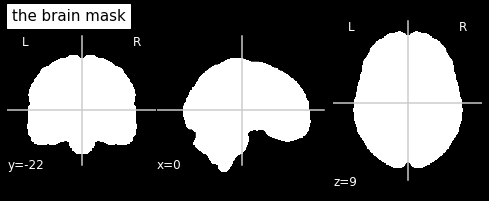

In [48]:
#* Build brain mask to restrict analysis within the brain
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)

<div class = 'alert alert-info'>

**Note:** In the lecture's slides the ICA model was defined as $X = S A$.  The matrix $A$ was the mixing matrix. Here, the Fast ICA model is defined as: $S = X W$. The matrix $W$ is the un-mixing matrix (inverse of $A$).
</div>

In [50]:
#* Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [4,]#10]#20, 60 ...]

## NOTE that 60 components can be computational costly

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]


for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    ### YOUR CODE HERE
    ### BEGIN SOLUTION
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    ### END SOLUTION
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ### BEGIN SOLUTION
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)
    ### END SOLUTION
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 4
Running FastICA with n = 4 components
(271633, 4)
Done


In [51]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

The shape of the estimated Sources is: (271633, 4)


In [52]:
#* Information needed for plotting -- these will be needed also for later (PLS)

#* Read  contrast maps of all subjects and build the X matrix
data_dir_template = 'PLS_data/sub_{}/contrastMap.nii'

#* Read T1-weighted template
T1w_img = nib.load('PLS_data/T1w_restore_brain.nii')

Number of components:  4


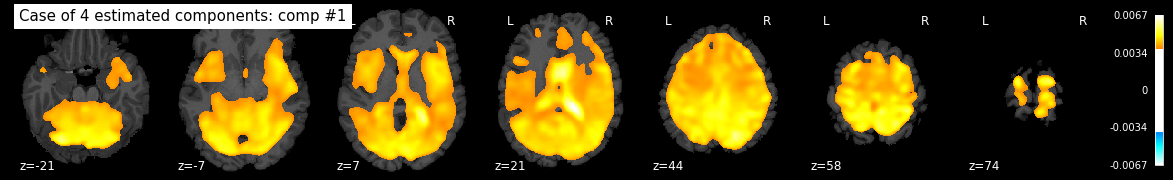

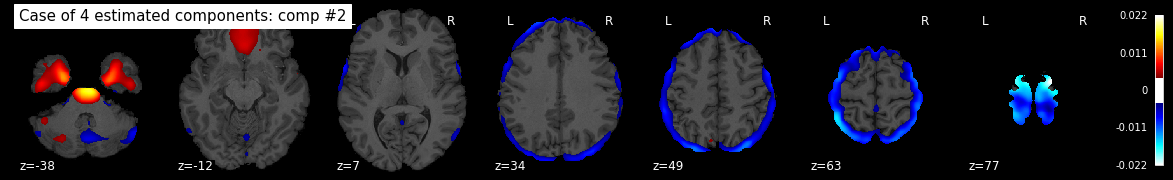

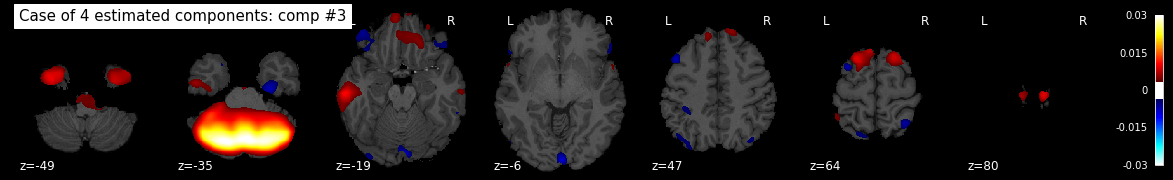

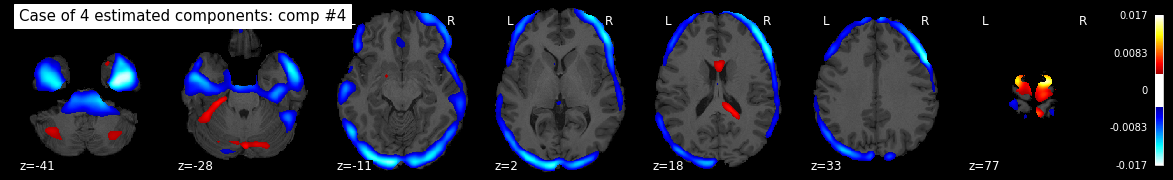

In [53]:
#* Plot the group-level independent components for the different number of requested components.
## Here you can use only 3 components to reduce the plots
## e.g. uncomment this if you used more than 3 values before
# nb_components = nb_components[:3]

for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(4, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

Now, copy-paste the cell above but change the display mode of the `plot_stat_map` function to be `ortho` instead of `z`.

Number of components:  4


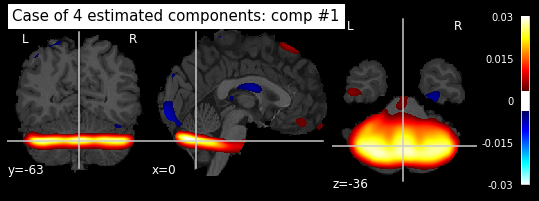

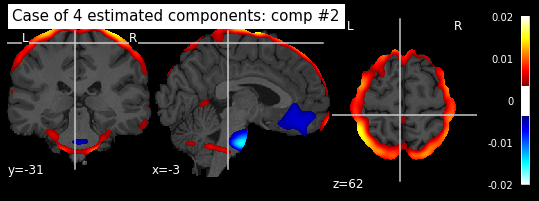

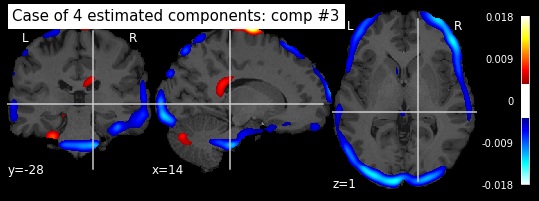

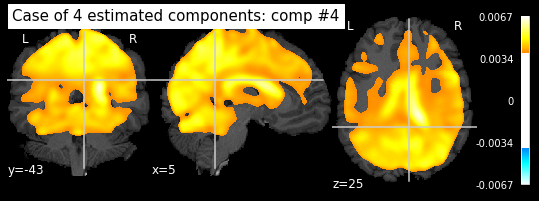

Number of components:  10


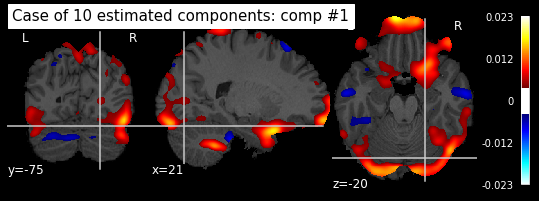

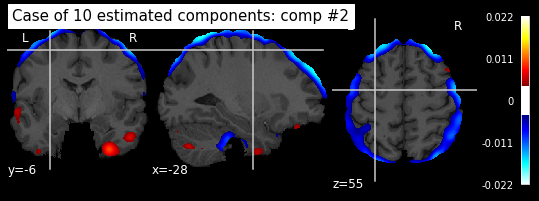

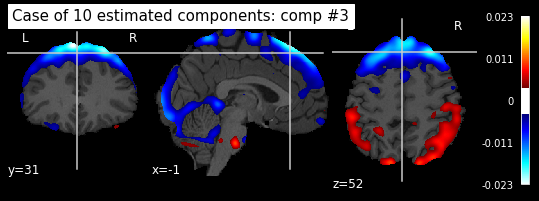

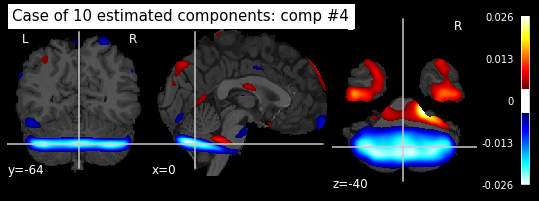

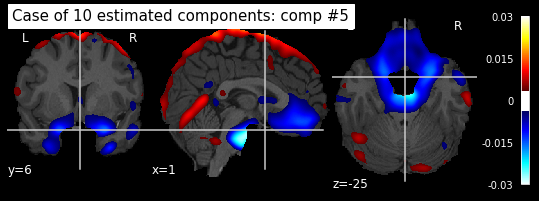

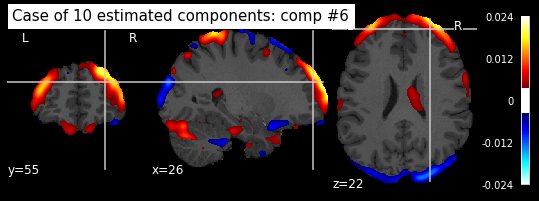

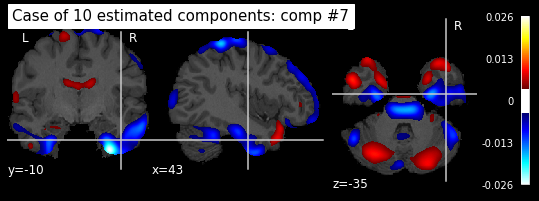

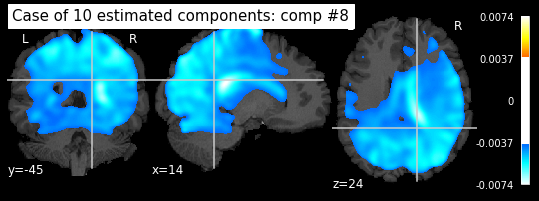

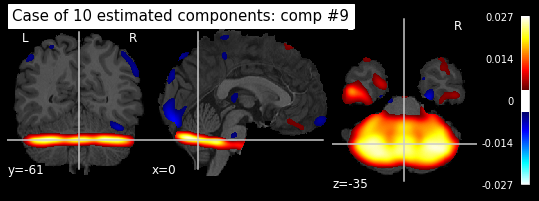

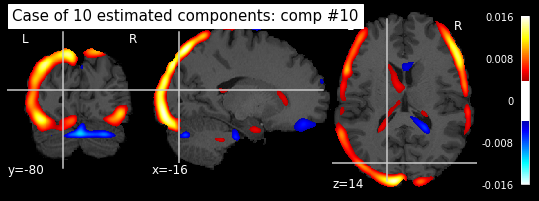

In [35]:
### BEGIN SOLUTION
#* Plot the group-level independent components for the different number of requested components.
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

### END SOLUTION

#### Reflection points: observe what happens when increasing the number of components:

Using more independent components doesn't always provide more useful information!